# Predicting Star Temperature with Elastic Net Linear Regression
Using the Open Exoplanet Catalogue database: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue/

## Data License
Copyright (C) 2012 Hanno Rein

Permission is hereby granted, free of charge, to any person obtaining a copy of this database and associated scripts (the "Database"), to deal in the Database without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Database, and to permit persons to whom the Database is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Database. A reference to the Database shall be included in all scientific publications that make use of the Database.

THE DATABASE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE DATABASE OR THE USE OR OTHER DEALINGS IN THE DATABASE.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

stars = pd.read_csv('../../ch_10/data/stars.csv')
stars.head()

,magJ,name,radius,spectraltype,magB,magV,temperature,magK,mass,metallicity,magH,planets
0,2.943,11 Com,19.000,G8 III,5.740,4.740,4742.0,2.282,2.70,-0.350,2.484,1.0
1,2.876,11 UMi,24.080,K4III,6.415,5.024,4340.0,1.939,1.80,0.040,2.091,1.0
2,3.019,14 And,11.000,K0III,6.240,5.220,4813.0,2.331,2.20,-0.240,2.608,1.0
3,5.158,14 Her,0.708,K0 V,7.570,6.670,5311.0,4.714,1.00,0.430,4.803,2.0
4,5.090,16 Cygni A,1.243,G2V,6.590,5.950,5825.0,4.430,1.11,0.096,4.720,0.0


## Train test split

In [2]:
from sklearn.model_selection import train_test_split

data = stars[['metallicity', 'temperature', 'magJ', 'radius', 'magB', 'magV', 'magK', 'mass', 'planets']].dropna()
y = data.pop('temperature')
X = data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

## Grid search for best hyperparameters in elastic net pipeline

In [3]:
%%capture 
# don't show warning messages or output for this cell
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([('scale', MinMaxScaler()), ('net', ElasticNet(random_state=0))])

search_space = {
    'net__alpha' : [0.1, 0.5, 1, 1.5, 2, 5],
    'net__l1_ratio' : np.linspace(0, 1, num=10),
    'net__fit_intercept' : [True, False]
}

elastic_net = GridSearchCV(pipeline, search_space, cv=5).fit(X_train, y_train)

In [4]:
elastic_net.best_params_

{'net__alpha': 0.1, 'net__fit_intercept': True, 'net__l1_ratio': 1.0}

## R squared

In [5]:
elastic_net.score(X_test, y_test) # R-squared

0.9087733907405916

## Model equation

In [6]:
[(coef, feature) for coef, feature in zip(elastic_net.best_estimator_.named_steps['net'].coef_, X_train.columns)]

[(2.2349719309644196, 'metallicity'),
 (-9551.259698607968, 'magJ'),
 (-5.471624568863697, 'radius'),
 (-6238.5505443056545, 'magB'),
 (-4294.056700081231, 'magV'),
 (19838.577173743968, 'magK'),
 (756.199312606241, 'mass'),
 (-254.60426328226285, 'planets')]

In [7]:
elastic_net.best_estimator_.named_steps['net'].intercept_

5247.3711305376255

## Residuals

array([<matplotlib.axes._subplots.AxesSubplot object at 0x131D25B0>,
      dtype=object)

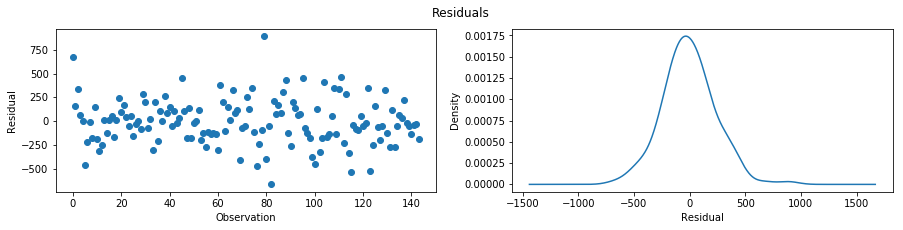

In [8]:
from ml_utils.regression import plot_residuals
plot_residuals(y_test, elastic_net.predict(X_test))